While the data itself is clarly understandable, what kind of analysis can be done on it I think really depends on what questions we are answering. However, I think the following analyses are feasible:
- Studying correlation between sensors to determine what environment they are set up in, or spacial correlation in general
           - Eg: If two sensors have ~1 correlation, it could mean that they both are setup in natural environments(outdoors) or both in the same controlled environment. 
           - poor correlation would mean the opposite.
- Using correlated sensors to populate missing data
- Detecting anamolies in the sensor readings and diagnosing the cause of sensor malfunction

        

<b>In this notebook, I have focussed on populating missing values using K nearest neighbors. 
Some of the challenges were: 
    - Handling nan values. Python packages dont provide much support for handling nan s and I had to write much of the code, including KNN.
    - The formatting only added to the difficulty. Normalizing datetime required me to convert datetime to a numeric value. Pandas documentation is not very neatly organized. 
    

In [392]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from  scipy.spatial import distance as dist

Reading the csv as a pandas dataframe

In [3]:
dataDf=pd.read_csv('data.txt',delimiter=' ',header=None)

In [4]:
dataDf.columns=['date:yyyy-mm-dd','time:hh:mm:ss.xxx','epoch','moteid','temperature','humidity','light','voltage']

In [5]:
dataDf.head(5)

,date:yyyy-mm-dd,time:hh:mm:ss.xxx,epoch,moteid,temperature,humidity,light,voltage
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964


Pandas allows us to take a quick glance at the count and density of each of its columns

In [41]:
dataDf.count()

date:yyyy-mm-dd      2313682
time:hh:mm:ss.xxx    2313682
epoch                2313682
moteid               2313156
temperature          2312781
humidity             2312780
light                2219804
voltage              2313156
dtype: int64

As was mentioned in, there clearly are missing values. 

 *******************************************************************************************

<b>Lets see what the data holds. Lets extract the numbers for one mote and for one day and plot. Line graphs will be ideal, given that this is time series data.</b>

<b>Checking if the data in data_day1mote1 is alright.</b>

In [9]:
data_day1mote1.count()

date:yyyy-mm-dd      1317
time:hh:mm:ss.xxx    1317
epoch                1317
moteid               1317
temperature          1317
humidity             1317
light                1317
voltage              1317
dtype: int64

<b>All rows have values. The values may be incorrect or even null, in which case, the next steps will show</b>

In [10]:
tempDay1=list(data_day1mote1['temperature'])
humidityDay1=list(data_day1mote1['humidity'])
lightDay1=list(data_day1mote1['light'])
voltageDay1=list(data_day1mote1['voltage'])
hrDay1=[int(i.split(':')[0]) for i in list(data_day1mote1['time:hh:mm:ss.xxx'])]

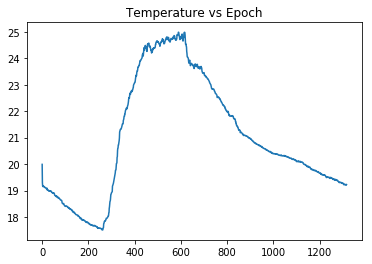

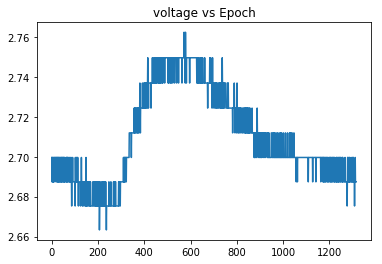

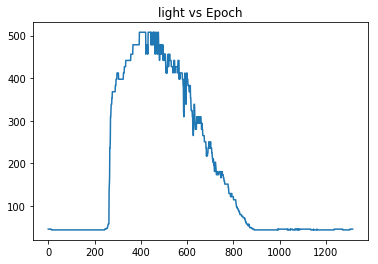

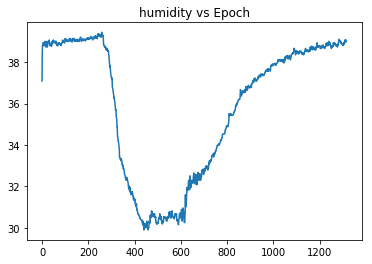

In [11]:
plt.figure()
plt.plot(tempDay1)
plt.title('Temperature vs Epoch')
plt.show()
###
plt.figure()
plt.plot(voltageDay1)
plt.title('voltage vs Epoch')
plt.show()
###
plt.figure()
plt.plot(lightDay1)
plt.title('light vs Epoch')
plt.show()
###
plt.figure()
plt.plot(humidityDay1)
plt.title('humidity vs Epoch')
plt.show()

<b>Temperature and humidity are clearly understandable. Temperature is least in the early morning, during which time humidity is the highest. Temperature reaches its highest in the noon, which is when humidity is at its min. It almost looks like temperature has a perfect negative correlation with humidity</b>

In [40]:
import numpy as np

print("Examining correlatioins")
print(np.corrcoef(tempDay1,humidityDay1))
print("")
print(np.corrcoef(tempDay1,lightDay1))
print("")
print(np.corrcoef(humidityDay1,lightDay1))
print("")

Examining correlatioins
[[ 1.        -0.9522238]
 [-0.9522238  1.       ]]

[[1.         0.71891054]
 [0.71891054 1.        ]]

[[ 1.         -0.86978933]
 [-0.86978933  1.        ]]



<b>Voila! A correlation of -0.95 is strong and can be used to make strong assumptions. Indeed, this will have to be verified for other days. The best way would be to take random samples</b>

<b>Examining voltage by zooming in</b>

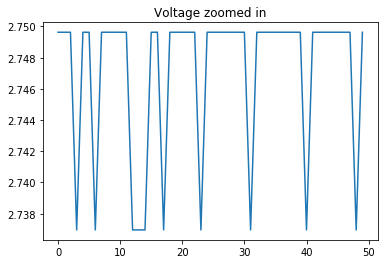

In [14]:
plt.plot(voltageDay1[500:550])
plt.title('Voltage zoomed in')
plt.show()

In [16]:
dataDf.isnull().values.any()

True

*********************************************************************************************

**************************************************************************************************

<h1>Fixing the missing values</h1>

In [178]:
dataDf.count()

date:yyyy-mm-dd      2303290
time:hh:mm:ss.xxx    2303290
epoch                2303290
moteid               2303290
temperature          2302918
humidity             2302919
light                2210085
voltage              2303290
x                    2303290
y                    2303290
dtype: int64

I note that date, time have no missing values at all.

In [42]:
nanDf=dataDf[pd.isnull(dataDf).any(axis=1)]

In [156]:
93879-92978

901

In [43]:
nanDf.count()

date:yyyy-mm-dd      93879
time:hh:mm:ss.xxx    93879
epoch                93879
moteid               93353
temperature          92978
humidity             92977
light                    1
voltage              93353
dtype: int64

In [47]:
#Updating the df to have x and  y coordinates for each mote.
coordinDf=pd.read_csv('mote_locs.txt',header=None,delimiter=' ')
coordinDf.columns=['moteid','x','y']

In [44]:
#nanDf

,date:yyyy-mm-dd,time:hh:mm:ss.xxx,epoch,moteid,temperature,humidity,light,voltage
129122,2004-03-30,08:11:56.681052,53671,3.0,NaN,NaN,NaN,2.19970
180389,2004-02-28,02:21:16.59372,167,5.0,NaN,NaN,NaN,2.69964
180390,2004-02-28,03:42:46.678899,330,5.0,NaN,NaN,NaN,2.67532
180391,2004-02-28,05:20:16.549645,525,5.0,NaN,NaN,NaN,2.65143
180392,2004-02-28,09:32:47.471012,1030,5.0,NaN,NaN,NaN,2.65143
180393,2004-02-28,13:05:48.430632,1456,5.0,NaN,NaN,NaN,2.68742
180394,2004-02-28,13:19:17.080958,1483,5.0,NaN,NaN,NaN,2.68742
180395,2004-02-28,15:14:47.695172,1714,5.0,NaN,NaN,NaN,2.67532
180396,2004-02-28,16:30:49.511264,1866,5.0,NaN,NaN,NaN,2.66332
180397,2004-02-28,16:56:48.403599,1918,5.0,NaN,NaN,NaN,2.67532


I observe that several rows have temp, humidity and light missing. Time stamp is not missing in any row. 

<b>Strategy: I begin by discarding rows with missing mote ids. It is possible, I think to predict the moot id, but I will focus on temp, humid and light. To predict missing rows, I will be using taking advantage of the fact that after discarding rows without moteid, all the rows have timestamp, x and y coordinates. 

I plan to find k_NN of each row that has atleast one missing value, and replace the missing field with the average of values in the corresponding columns of k-NN </b>

In [69]:
coordinDf["moteid"] = coordinDf["moteid"].astype(float)

In [70]:
coordinDf.head(5)

,moteid,x,y
0,1.0,21.5,23
1,2.0,24.5,20
2,3.0,19.5,19
3,4.0,22.5,15
4,5.0,24.5,12


Merging the location DF and the data DF

In [72]:
dataDf= pd.merge(dataDf,coordinDf,on=['moteid'])

In [74]:
dataDf.head(5)

,date:yyyy-mm-dd,time:hh:mm:ss.xxx,epoch,moteid,temperature,humidity,light,voltage,x,y
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397,21.5,23
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964,21.5,23
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742,21.5,23
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742,21.5,23
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964,21.5,23


Lets begin by normalizing values. I am gonna treat each variable to have equal weightage. That means, I will have to convert time and date to an integer and then normalize them too. I will be discarding epoch from dataDf. 

In [111]:
#Converting to appropriate datatypes
dataDf['date:yyyy-mm-dd']=pd.to_datetime(dataDf['date:yyyy-mm-dd'])

dataDf['time:hh:mm:ss.xxx'] = pd.to_datetime(dataDf['time:hh:mm:ss.xxx'])
dataDf['time:hh:mm:ss.xxx']= [time.time() for time in dataDf['time:hh:mm:ss.xxx']]

In [208]:
normDf=pd.DataFrame()

In [243]:
from datetime import datetime, date, time, timedelta
def timeToSec(timeobj):
    t = datetime.combine(date.min, timeobj) - datetime.min
    return(t.total_seconds())

In [245]:
#Normalizing date
series =dataDf['date:yyyy-mm-dd']
values = series.values
values = values.reshape((len(values), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
normalized = [i[0] for i in scaler.transform(values)]
normDf['date']=normalized


#Normalizaing time
series =dataDf['time:hh:mm:ss.xxx']
values = [[timeToSec(i)] for i in series.values]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
normalized = [i[0] for i in scaler.transform(values)]
normDf['time']=normalized




/home/suryattheja/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [256]:
for col in ['temperature','humidity','light']:
    series =dataDf[col]
    values=list(series.values)
    maxim=max(values)
    minim=min(values)
    normalized=[]
    for i in values:
        if(np.isnan(i)):
            normalized.append(np.NaN)
        else:
            normalized.append((maxim-i)/(maxim-minim))
    normDf[col]=normalized

<b>Finally, we have the normalized data ready</b>

In [315]:
normNonan=normDf.dropna(axis=0, how='any')

*******************************************************************

At this point, I have NormDF, a DF with normalized values and normNoNan, normalized df with nan values dropped.

<h2>Implementing K -NN</h2>

Strategy: For each row with NaNs in them, pass the available values to the below method. Eg, if a row has date, time and temp. and the other parameters are missing, pass the available values from the row to the getKNN function. 
This method searches for nearest neighbors in the df - normNoNan and returns a fully populated row with the closest match. The thus obtained values may then replace the NaN s in the input row.

In [399]:
def getKNN(date=-1,time=-1,temperature=-1,humidity=-1,light=-1,k=5):
    searchCols=[]
    searchTerm=[]
    if(date>0):
        searchCols.append('date')    
        searchTerm.append(date)
    if(time)>0:
        searchCols.append('time')
        searchTerm.append(time)
    if(temperature)>0:
        searchCols.append('temperature')
        searchTerm.append(temperature)
    if(humidity)>0:
        searchCols.append('humidity')
        searchTerm.append(humidity)
    if(light)>0:
        searchCols.append('light')
        searchTerm.append(light)
    searchMat=normNonan[searchCols].as_matrix()
    
    distances=[]
    
    for row in range(searchMat.shape[0]):
        distances.append((row,dist.euclidean(searchTerm,searchMat[row,:])))
    
    distances=sorted(distances,key=lambda x:x[1])
    
    return(distances[:k])

Test: Lets take the first row[Row 0] and pretend to be not having values for temperature and light. We hence pass date, time and humidity to the getKNN function with k=1. It searches for the closes match and returns the row number that is the closest match to the available values and hence the best candidate to replace the Nans.

In [257]:
normDf.head(4)

,date,time,temperature,humidity,light
0,0.914286,0.151571,0.621309,0.015507,0.994024
1,0.000000,0.041157,0.862281,0.011010,0.975598
2,0.000000,0.043939,0.863899,0.010860,0.975598
3,0.000000,0.046018,0.864223,0.010822,0.975598


Not surprisingly, the output says that the closest match is the first row itself!

In [398]:
getKNN(date=0.914286,time=0.151571,humidity=0.621309)

(0, 4.3402287182382287e-07)

The KNN algorithm could be written in a much better way using Kd trees. With the limited time and library support available to handle NaNs, I stop here. 